# Chapter 6: Robust Optimization with Cauchy Kernel

## Learning Objectives
- Understand why robust optimization is necessary in SLAM
- Implement various robust loss functions (Cauchy, Huber, Tukey)
- Compare the effect of different kernels on optimization
- Handle outliers in pose graph optimization
- Visualize the impact of robust kernels on convergence

## 1. Why Robust Optimization?

In real-world SLAM applications, measurements often contain outliers due to:
- Incorrect loop closure detections
- Sensor noise and failures
- Dynamic objects in the environment
- Data association errors

Standard least-squares optimization is highly sensitive to outliers because it uses squared errors, giving large errors disproportionate influence.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import symforce
symforce.set_epsilon_to_number(1e-8)
import symforce.symbolic as sf
from symforce import ops
from symforce.values import Values
from symforce.opt.optimizer import Optimizer
from symforce.opt.factor import Factor
from typing import List, Tuple, Dict, Optional
import time

## 2. Robust Loss Functions

Robust loss functions modify the squared error to reduce the influence of outliers:

- **L2 (Standard)**: $\rho(e) = \frac{1}{2}e^2$
- **Huber**: $\rho(e) = \begin{cases} \frac{1}{2}e^2 & |e| \leq \delta \\ \delta|e| - \frac{1}{2}\delta^2 & |e| > \delta \end{cases}$
- **Cauchy**: $\rho(e) = \frac{c^2}{2} \log\left(1 + \frac{e^2}{c^2}\right)$
- **Tukey**: $\rho(e) = \begin{cases} \frac{c^2}{6}\left(1 - \left(1 - \frac{e^2}{c^2}\right)^3\right) & |e| \leq c \\ \frac{c^2}{6} & |e| > c \end{cases}$

In [13]:
class RobustKernel:
    """Base class for robust kernels"""
    def __init__(self, delta: float = 1.0):
        self.delta = delta
    
    def weight(self, error: float) -> float:
        """Compute weight for weighted least squares"""
        raise NotImplementedError
    
    def loss(self, error: float) -> float:
        """Compute robust loss"""
        raise NotImplementedError

class L2Kernel(RobustKernel):
    """Standard L2 loss (no robustness)"""
    def weight(self, error: float) -> float:
        return 1.0
    
    def loss(self, error: float) -> float:
        return 0.5 * error**2

class HuberKernel(RobustKernel):
    """Huber robust kernel"""
    def weight(self, error: float) -> float:
        abs_error = abs(error)
        if abs_error <= self.delta:
            return 1.0
        else:
            return self.delta / abs_error
    
    def loss(self, error: float) -> float:
        abs_error = abs(error)
        if abs_error <= self.delta:
            return 0.5 * error**2
        else:
            return self.delta * abs_error - 0.5 * self.delta**2

class CauchyKernel(RobustKernel):
    """Cauchy (Lorentzian) robust kernel"""
    def weight(self, error: float) -> float:
        return 1.0 / (1.0 + (error / self.delta)**2)
    
    def loss(self, error: float) -> float:
        return 0.5 * self.delta**2 * np.log(1.0 + (error / self.delta)**2)

class TukeyKernel(RobustKernel):
    """Tukey biweight robust kernel"""
    def weight(self, error: float) -> float:
        abs_error = abs(error)
        if abs_error <= self.delta:
            return (1.0 - (error / self.delta)**2)**2
        else:
            return 0.0
    
    def loss(self, error: float) -> float:
        abs_error = abs(error)
        if abs_error <= self.delta:
            r = error / self.delta
            return (self.delta**2 / 6.0) * (1.0 - (1.0 - r**2)**3)
        else:
            return self.delta**2 / 6.0

## 3. Visualizing Robust Kernels

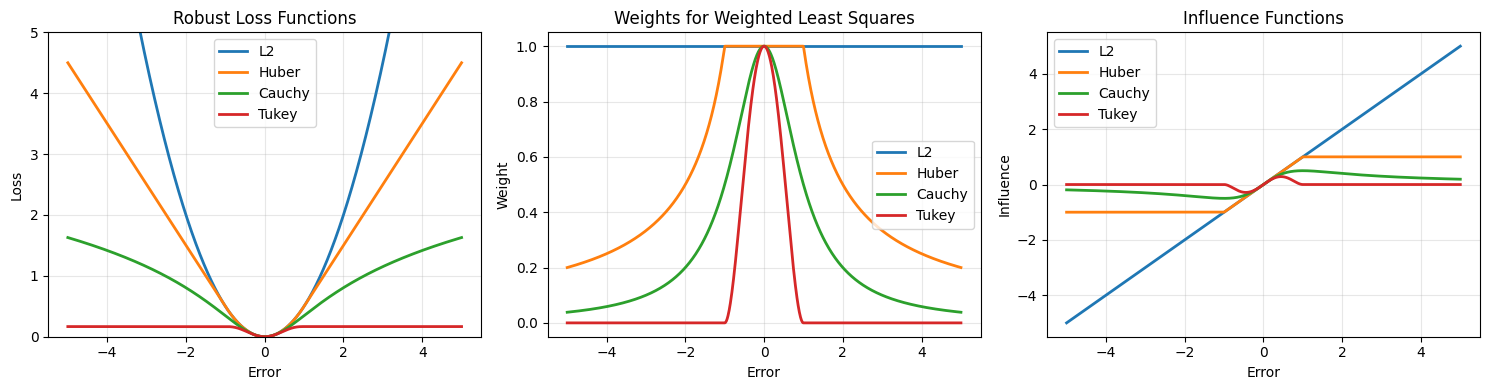

In [14]:
# Visualize different robust kernels
errors = np.linspace(-5, 5, 1000)
delta = 1.0

kernels = {
    'L2': L2Kernel(delta),
    'Huber': HuberKernel(delta),
    'Cauchy': CauchyKernel(delta),
    'Tukey': TukeyKernel(delta)
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot loss functions
ax = axes[0]
for name, kernel in kernels.items():
    losses = [kernel.loss(e) for e in errors]
    ax.plot(errors, losses, label=name, linewidth=2)
ax.set_xlabel('Error')
ax.set_ylabel('Loss')
ax.set_title('Robust Loss Functions')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 5])

# Plot weights
ax = axes[1]
for name, kernel in kernels.items():
    weights = [kernel.weight(e) for e in errors]
    ax.plot(errors, weights, label=name, linewidth=2)
ax.set_xlabel('Error')
ax.set_ylabel('Weight')
ax.set_title('Weights for Weighted Least Squares')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot influence functions (derivative of loss)
ax = axes[2]
for name, kernel in kernels.items():
    influences = []
    for e in errors:
        if name == 'L2':
            influences.append(e)
        else:
            influences.append(e * kernel.weight(e))
    ax.plot(errors, influences, label=name, linewidth=2)
ax.set_xlabel('Error')
ax.set_ylabel('Influence')
ax.set_title('Influence Functions')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Robust Pose Graph Optimizer

Now let's implement a pose graph optimizer with robust kernels using Iteratively Reweighted Least Squares (IRLS).

In [15]:
class RobustPoseGraphOptimizer:
    def __init__(self, kernel: RobustKernel = None):
        self.vertices = {}  # id -> (x, y, theta)
        self.edges = []     # (i, j, dx, dy, dtheta, info_matrix)
        self.kernel = kernel if kernel else L2Kernel()
        self.fixed_vertices = set()
    
    def add_vertex(self, vertex_id: int, x: float, y: float, theta: float):
        self.vertices[vertex_id] = np.array([x, y, theta])
    
    def add_edge(self, i: int, j: int, dx: float, dy: float, dtheta: float, 
                 info_matrix: np.ndarray = None):
        if info_matrix is None:
            info_matrix = np.eye(3)
        self.edges.append((i, j, np.array([dx, dy, dtheta]), info_matrix))
    
    def fix_vertex(self, vertex_id: int):
        self.fixed_vertices.add(vertex_id)
    
    def _normalize_angle(self, angle: float) -> float:
        return np.arctan2(np.sin(angle), np.cos(angle))
    
    def _compute_error(self, i: int, j: int, measurement: np.ndarray) -> np.ndarray:
        """Compute error between predicted and measured relative pose"""
        xi = self.vertices[i]
        xj = self.vertices[j]
        
        # Predicted relative pose
        c = np.cos(xi[2])
        s = np.sin(xi[2])
        dx_pred = c * (xj[0] - xi[0]) + s * (xj[1] - xi[1])
        dy_pred = -s * (xj[0] - xi[0]) + c * (xj[1] - xi[1])
        dtheta_pred = self._normalize_angle(xj[2] - xi[2])
        
        # Error
        error = np.array([
            dx_pred - measurement[0],
            dy_pred - measurement[1],
            self._normalize_angle(dtheta_pred - measurement[2])
        ])
        
        return error
    
    def _compute_jacobians(self, i: int, j: int) -> Tuple[np.ndarray, np.ndarray]:
        """Compute Jacobians of error with respect to poses i and j"""
        xi = self.vertices[i]
        xj = self.vertices[j]
        
        c = np.cos(xi[2])
        s = np.sin(xi[2])
        dx = xj[0] - xi[0]
        dy = xj[1] - xi[1]
        
        # Jacobian with respect to pose i
        Ji = np.array([
            [-c, -s, -s * dx + c * dy],
            [s, -c, -c * dx - s * dy],
            [0, 0, -1]
        ])
        
        # Jacobian with respect to pose j
        Jj = np.array([
            [c, s, 0],
            [-s, c, 0],
            [0, 0, 1]
        ])
        
        return Ji, Jj
    
    def optimize(self, max_iterations: int = 20, tolerance: float = 1e-6, 
                 verbose: bool = True) -> Dict[str, List[float]]:
        """Optimize using Iteratively Reweighted Least Squares (IRLS)"""
        n_vertices = len(self.vertices)
        vertex_ids = sorted(self.vertices.keys())
        id_to_idx = {v_id: idx for idx, v_id in enumerate(vertex_ids)}
        
        history = {
            'total_error': [],
            'max_update': [],
            'iteration_time': []
        }
        
        for iteration in range(max_iterations):
            start_time = time.time()
            
            # Build system matrix
            H = np.zeros((n_vertices * 3, n_vertices * 3))
            b = np.zeros(n_vertices * 3)
            
            total_error = 0.0
            
            for i, j, measurement, info_matrix in self.edges:
                # Compute error and Jacobians
                error = self._compute_error(i, j, measurement)
                Ji, Jj = self._compute_jacobians(i, j)
                
                # Compute robust weight
                error_norm = np.sqrt(error.T @ info_matrix @ error)
                weight = self.kernel.weight(error_norm)
                
                # Apply weight to information matrix
                weighted_info = weight * info_matrix
                
                # Add contribution to H and b
                idx_i = id_to_idx[i] * 3
                idx_j = id_to_idx[j] * 3
                
                # H_ii += Ji^T * Omega * Ji
                H[idx_i:idx_i+3, idx_i:idx_i+3] += Ji.T @ weighted_info @ Ji
                # H_ij += Ji^T * Omega * Jj
                H[idx_i:idx_i+3, idx_j:idx_j+3] += Ji.T @ weighted_info @ Jj
                # H_ji += Jj^T * Omega * Ji
                H[idx_j:idx_j+3, idx_i:idx_i+3] += Jj.T @ weighted_info @ Ji
                # H_jj += Jj^T * Omega * Jj
                H[idx_j:idx_j+3, idx_j:idx_j+3] += Jj.T @ weighted_info @ Jj
                
                # b_i += -Ji^T * Omega * error
                b[idx_i:idx_i+3] += -Ji.T @ weighted_info @ error
                # b_j += -Jj^T * Omega * error
                b[idx_j:idx_j+3] += -Jj.T @ weighted_info @ error
                
                # Accumulate total error (using robust loss)
                total_error += self.kernel.loss(error_norm)
            
            # Fix first vertex
            for fixed_id in self.fixed_vertices:
                idx = id_to_idx[fixed_id] * 3
                H[idx:idx+3, :] = 0
                H[:, idx:idx+3] = 0
                H[idx:idx+3, idx:idx+3] = np.eye(3)
                b[idx:idx+3] = 0
            
            # Solve H * dx = b
            try:
                dx = np.linalg.solve(H, b)
            except np.linalg.LinAlgError:
                print(f"Warning: Singular matrix at iteration {iteration}")
                break
            
            # Update poses
            for v_id in vertex_ids:
                idx = id_to_idx[v_id] * 3
                self.vertices[v_id] += dx[idx:idx+3]
                # Normalize angle
                self.vertices[v_id][2] = self._normalize_angle(self.vertices[v_id][2])
            
            # Record history
            max_update = np.max(np.abs(dx))
            iteration_time = time.time() - start_time
            
            history['total_error'].append(total_error)
            history['max_update'].append(max_update)
            history['iteration_time'].append(iteration_time)
            
            if verbose:
                print(f"Iteration {iteration}: error = {total_error:.6f}, "
                      f"max update = {max_update:.6f}, time = {iteration_time:.3f}s")
            
            # Check convergence
            if max_update < tolerance:
                if verbose:
                    print(f"Converged after {iteration + 1} iterations")
                break
        
        return history

## 5. Testing with Outliers

Let's create a test scenario with outliers to demonstrate the effectiveness of robust optimization.

In [16]:
def create_test_graph_with_outliers(n_poses: int = 20, outlier_ratio: float = 0.1):
    """Create a circular trajectory with some outlier measurements"""
    optimizer = RobustPoseGraphOptimizer()
    
    # Ground truth poses (circle)
    radius = 10.0
    angles = np.linspace(0, 2*np.pi, n_poses, endpoint=False)
    ground_truth = []
    
    for i, angle in enumerate(angles):
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        theta = angle + np.pi/2  # Tangent direction
        ground_truth.append([x, y, theta])
        
        # Add noisy initial guess
        x_init = x + np.random.normal(0, 0.5)
        y_init = y + np.random.normal(0, 0.5)
        theta_init = theta + np.random.normal(0, 0.1)
        optimizer.add_vertex(i, x_init, y_init, theta_init)
    
    # Fix first vertex
    optimizer.fix_vertex(0)
    
    # Add sequential edges
    for i in range(n_poses):
        j = (i + 1) % n_poses
        
        # Compute true relative pose
        dx_true = ground_truth[j][0] - ground_truth[i][0]
        dy_true = ground_truth[j][1] - ground_truth[i][1]
        c = np.cos(ground_truth[i][2])
        s = np.sin(ground_truth[i][2])
        dx_local = c * dx_true + s * dy_true
        dy_local = -s * dx_true + c * dy_true
        dtheta = ground_truth[j][2] - ground_truth[i][2]
        
        # Add noise
        dx_meas = dx_local + np.random.normal(0, 0.1)
        dy_meas = dy_local + np.random.normal(0, 0.1)
        dtheta_meas = dtheta + np.random.normal(0, 0.05)
        
        # Randomly make some measurements outliers
        if np.random.random() < outlier_ratio:
            # Add large error to create outlier
            dx_meas += np.random.normal(0, 2.0)
            dy_meas += np.random.normal(0, 2.0)
            dtheta_meas += np.random.normal(0, 0.5)
        
        optimizer.add_edge(i, j, dx_meas, dy_meas, dtheta_meas)
    
    # Add loop closure edges with higher chance of outliers
    n_loop_closures = 5
    for _ in range(n_loop_closures):
        i = np.random.randint(0, n_poses - 5)
        j = i + np.random.randint(5, min(n_poses - i, 10))
        
        # Compute relative pose
        dx_true = ground_truth[j][0] - ground_truth[i][0]
        dy_true = ground_truth[j][1] - ground_truth[i][1]
        c = np.cos(ground_truth[i][2])
        s = np.sin(ground_truth[i][2])
        dx_local = c * dx_true + s * dy_true
        dy_local = -s * dx_true + c * dy_true
        dtheta = ground_truth[j][2] - ground_truth[i][2]
        
        # Add noise (higher chance of outliers for loop closures)
        dx_meas = dx_local + np.random.normal(0, 0.2)
        dy_meas = dy_local + np.random.normal(0, 0.2)
        dtheta_meas = dtheta + np.random.normal(0, 0.1)
        
        if np.random.random() < 0.3:  # 30% outlier rate for loop closures
            dx_meas += np.random.normal(0, 3.0)
            dy_meas += np.random.normal(0, 3.0)
            dtheta_meas += np.random.normal(0, 1.0)
        
        optimizer.add_edge(i, j, dx_meas, dy_meas, dtheta_meas)
    
    return optimizer, np.array(ground_truth)

## 6. Comparing Different Kernels

In [17]:
# Create test scenario
np.random.seed(42)
n_poses = 30
outlier_ratio = 0.15

# Test different kernels
kernels_to_test = {
    'L2 (No Robustness)': L2Kernel(),
    'Huber': HuberKernel(delta=1.0),
    'Cauchy': CauchyKernel(delta=1.0),
    'Tukey': TukeyKernel(delta=2.0)
}

results = {}
optimizers = {}

for kernel_name, kernel in kernels_to_test.items():
    print(f"\nOptimizing with {kernel_name} kernel...")
    
    # Create fresh optimizer with same initial conditions
    optimizer, ground_truth = create_test_graph_with_outliers(n_poses, outlier_ratio)
    optimizer.kernel = kernel
    
    # Store initial poses for visualization
    initial_poses = {k: v.copy() for k, v in optimizer.vertices.items()}
    
    # Optimize
    history = optimizer.optimize(max_iterations=50, verbose=False)
    
    results[kernel_name] = history
    optimizers[kernel_name] = optimizer
    
    print(f"Final error: {history['total_error'][-1]:.6f}")
    print(f"Iterations: {len(history['total_error'])}")


Optimizing with L2 (No Robustness) kernel...
Final error: 691.295658
Iterations: 50

Optimizing with Huber kernel...
Final error: 2.566513
Iterations: 15

Optimizing with Cauchy kernel...
Final error: 2.157696
Iterations: 23

Optimizing with Tukey kernel...
Final error: 2.014193
Iterations: 6


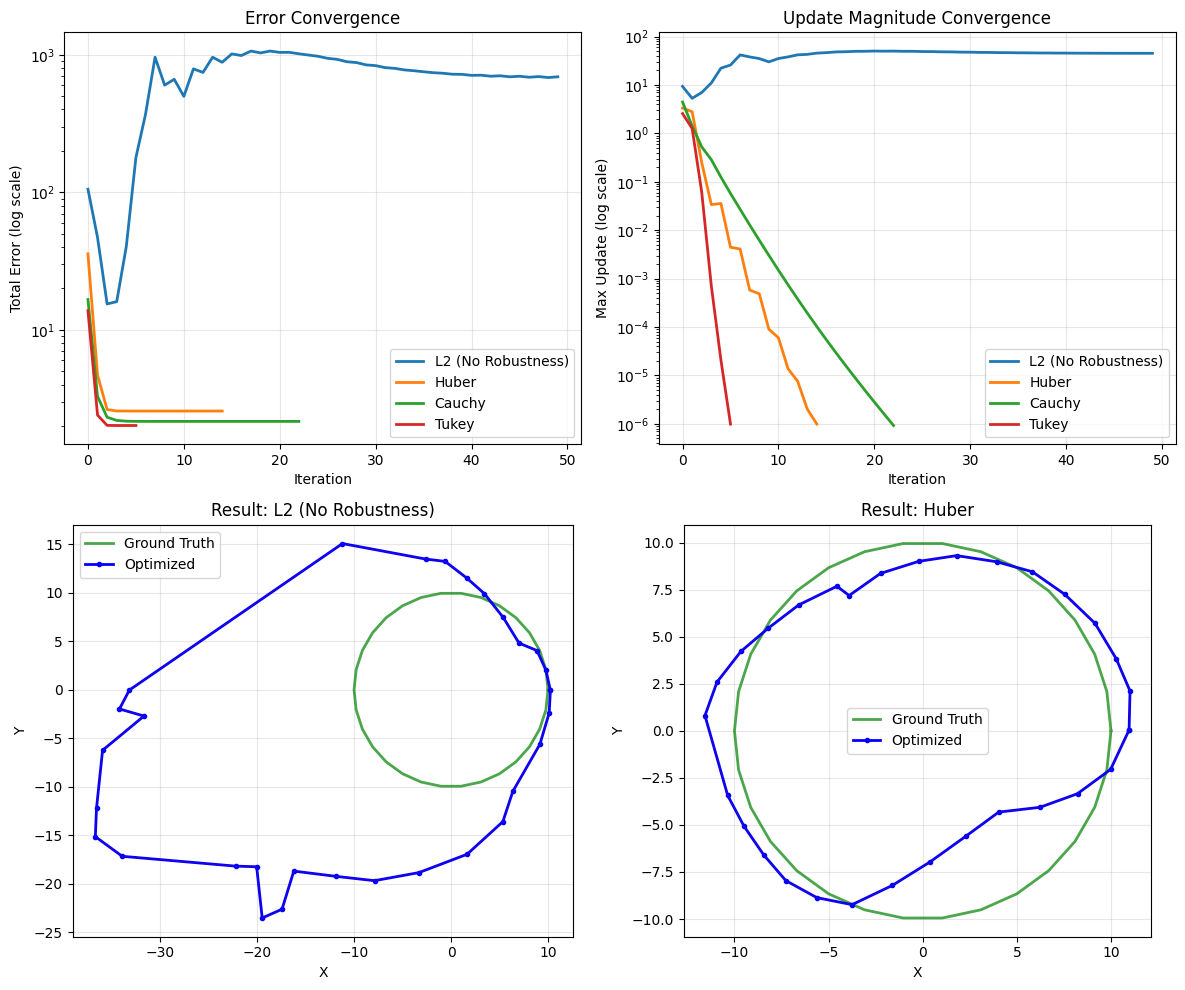

In [18]:
# Visualize convergence
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot error convergence
ax = axes[0, 0]
for kernel_name, history in results.items():
    ax.semilogy(history['total_error'], label=kernel_name, linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Total Error (log scale)')
ax.set_title('Error Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot max update convergence
ax = axes[0, 1]
for kernel_name, history in results.items():
    ax.semilogy(history['max_update'], label=kernel_name, linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Max Update (log scale)')
ax.set_title('Update Magnitude Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot final trajectories
for idx, (kernel_name, optimizer) in enumerate(optimizers.items()):
    if idx < 2:
        ax = axes[1, idx]
        
        # Plot ground truth
        gt_x = [p[0] for p in ground_truth]
        gt_y = [p[1] for p in ground_truth]
        ax.plot(gt_x + [gt_x[0]], gt_y + [gt_y[0]], 'g-', linewidth=2, 
                label='Ground Truth', alpha=0.7)
        
        # Plot optimized trajectory
        opt_poses = [optimizer.vertices[i] for i in sorted(optimizer.vertices.keys())]
        opt_x = [p[0] for p in opt_poses]
        opt_y = [p[1] for p in opt_poses]
        ax.plot(opt_x + [opt_x[0]], opt_y + [opt_y[0]], 'b-', linewidth=2, 
                label='Optimized', marker='o', markersize=3)
        
        # Plot edges (to show outliers)
        for i, j, _, _ in optimizer.edges[:n_poses]:  # Only sequential edges
            pi = optimizer.vertices[i]
            pj = optimizer.vertices[j]
            ax.plot([pi[0], pj[0]], [pi[1], pj[1]], 'r-', alpha=0.2, linewidth=0.5)
        
        ax.set_aspect('equal')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Result: {kernel_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Analyzing Edge Weights

Let's visualize which edges are identified as outliers by different robust kernels.

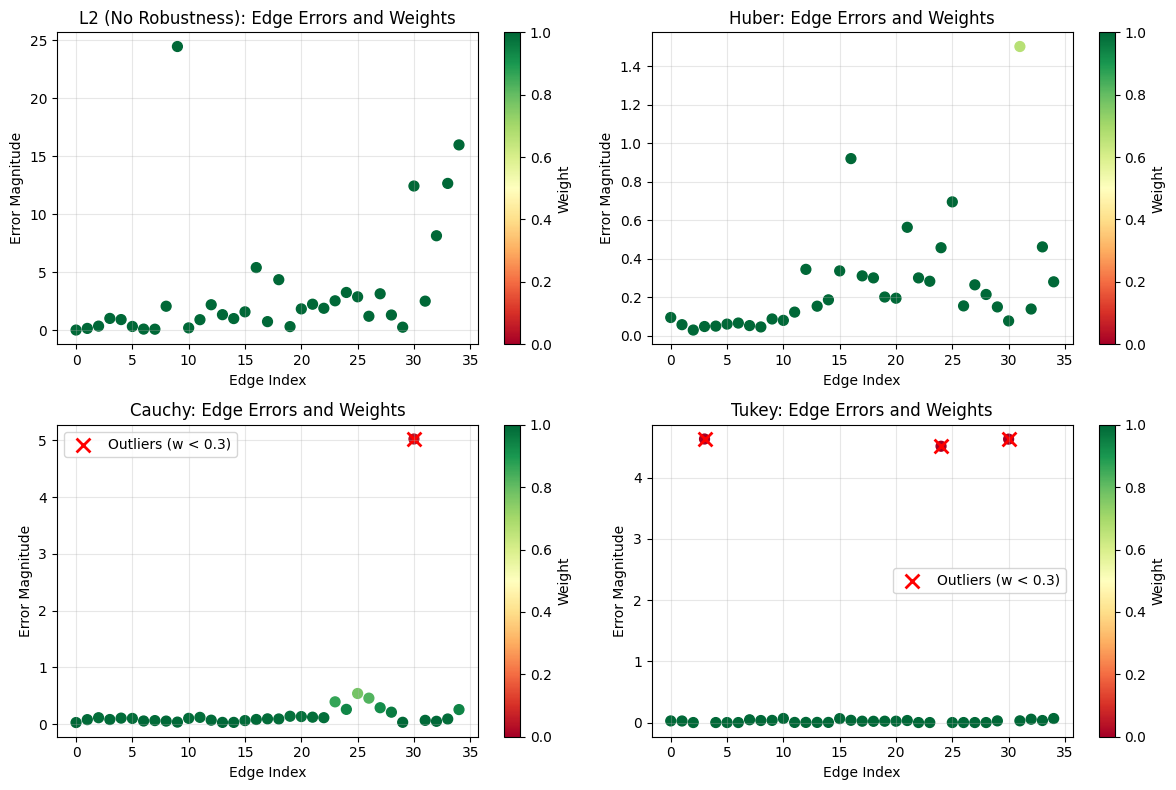

In [19]:
# Compute final weights for each edge with different kernels
edge_weights = {kernel_name: [] for kernel_name in kernels_to_test.keys()}

for kernel_name, optimizer in optimizers.items():
    weights = []
    errors = []
    
    for i, j, measurement, info_matrix in optimizer.edges:
        error = optimizer._compute_error(i, j, measurement)
        error_norm = np.sqrt(error.T @ info_matrix @ error)
        weight = optimizer.kernel.weight(error_norm)
        weights.append(weight)
        errors.append(error_norm)
    
    edge_weights[kernel_name] = (weights, errors)

# Visualize edge weights
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, (kernel_name, (weights, errors)) in enumerate(edge_weights.items()):
    ax = axes[idx]
    
    # Create scatter plot colored by weight
    edge_indices = np.arange(len(weights))
    scatter = ax.scatter(edge_indices, errors, c=weights, 
                        cmap='RdYlGn', vmin=0, vmax=1, s=50)
    
    ax.set_xlabel('Edge Index')
    ax.set_ylabel('Error Magnitude')
    ax.set_title(f'{kernel_name}: Edge Errors and Weights')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Weight')
    
    # Mark outliers (low weight edges)
    outlier_threshold = 0.3
    outlier_indices = [i for i, w in enumerate(weights) if w < outlier_threshold]
    if outlier_indices:
        ax.scatter(outlier_indices, [errors[i] for i in outlier_indices],
                  marker='x', s=100, c='red', linewidth=2, 
                  label=f'Outliers (w < {outlier_threshold})')
        ax.legend()

plt.tight_layout()
plt.show()

## 8. Performance Comparison

Let's compare the final trajectory errors for each kernel.

In [20]:
# Compute trajectory errors
trajectory_errors = {}

for kernel_name, optimizer in optimizers.items():
    errors = []
    for i in range(len(ground_truth)):
        gt = ground_truth[i]
        est = optimizer.vertices[i]
        
        # Position error
        pos_error = np.linalg.norm(gt[:2] - est[:2])
        
        # Orientation error
        angle_error = abs(optimizer._normalize_angle(gt[2] - est[2]))
        
        errors.append((pos_error, angle_error))
    
    trajectory_errors[kernel_name] = errors

# Create comparison table
print("\nTrajectory Error Statistics:")
print("-" * 80)
print(f"{'Kernel':<20} {'Mean Pos Error':<15} {'Max Pos Error':<15} "
      f"{'Mean Angle Error':<18} {'Max Angle Error':<15}")
print("-" * 80)

for kernel_name, errors in trajectory_errors.items():
    pos_errors = [e[0] for e in errors]
    angle_errors = [e[1] for e in errors]
    
    print(f"{kernel_name:<20} {np.mean(pos_errors):<15.4f} {np.max(pos_errors):<15.4f} "
          f"{np.mean(angle_errors):<18.4f} {np.max(angle_errors):<15.4f}")


Trajectory Error Statistics:
--------------------------------------------------------------------------------
Kernel               Mean Pos Error  Max Pos Error   Mean Angle Error   Max Angle Error
--------------------------------------------------------------------------------
L2 (No Robustness)   12.6600         30.6765         0.3562             1.5351         
Huber                1.9424          4.0903          0.2403             0.8254         
Cauchy               1.9384          4.4915          0.1611             0.6027         
Tukey                1.5762          2.4067          0.0649             0.1876         


## 9. Symforce Implementation with Robust Kernels

Let's implement a robust kernel using Symforce for automatic differentiation.

In [21]:
def cauchy_robust_residual(
    pose_i: sf.Pose2,
    pose_j: sf.Pose2,
    measurement: sf.Pose2,
    delta: sf.Scalar,
    epsilon: sf.Scalar
) -> sf.V3:
    """
    Compute robust residual using Cauchy kernel
    
    The Cauchy kernel is applied to the error norm:
    rho(e) = delta^2 * log(1 + (e/delta)^2)
    
    The residual is then: sqrt(2 * rho(||e||)) * e / ||e||
    """
    # Compute relative pose error
    T_ij_predicted = pose_i.inverse() * pose_j
    T_error = measurement.inverse() * T_ij_predicted
    
    # Extract error components
    error = sf.V3(
        T_error.position()[0],
        T_error.position()[1],
        T_error.rotation().to_tangent()[0]
    )
    
    # Compute error norm
    error_norm = error.norm(epsilon=epsilon)
    
    # Apply Cauchy robust function
    # rho(e) = delta^2 * log(1 + (e/delta)^2)
    rho = delta**2 * sf.log(1 + (error_norm / delta)**2)
    
    # Compute sqrt(2 * rho) which gives the robust residual magnitude
    robust_magnitude = sf.sqrt(2 * rho + epsilon)
    
    # Scale error to get robust residual
    # This ensures the Jacobian is correct
    robust_residual = (robust_magnitude / (error_norm + epsilon)) * error
    
    return robust_residual

# Test the Symforce robust kernel
from symforce.codegen import Codegen, CppConfig

# Generate optimized code
codegen = Codegen.function(
    func=cauchy_robust_residual,
    config=CppConfig()
)

# Generate Python function
cauchy_residual_py = codegen.with_jacobians(
    which_args=["pose_i", "pose_j"],
    include_results=True
).generate_function()

print("Generated robust residual function with automatic Jacobians!")

Generated robust residual function with automatic Jacobians!


## 10. Exercise: Adaptive Robust Kernels

Try implementing an adaptive robust kernel that adjusts its threshold based on the distribution of errors:

In [22]:
class AdaptiveCauchyKernel(RobustKernel):
    """Cauchy kernel with adaptive threshold based on error distribution"""
    def __init__(self, percentile: float = 0.7):
        super().__init__(delta=1.0)
        self.percentile = percentile
        self.error_history = []
    
    def update_threshold(self, errors: List[float]):
        """Update delta based on error distribution"""
        if len(errors) > 10:
            # Use median absolute deviation (MAD) for robust scale estimate
            median_error = np.median(errors)
            mad = np.median(np.abs(errors - median_error))
            # Scale factor for Cauchy distribution
            self.delta = 1.4826 * mad * self.percentile
    
    def weight(self, error: float) -> float:
        self.error_history.append(abs(error))
        return super().weight(error)

# TODO: Implement and test the adaptive kernel
# 1. Modify the optimizer to use the adaptive kernel
# 2. Update the threshold after each iteration
# 3. Compare with fixed-threshold kernels

## Summary

In this chapter, we learned:

1. **Why robust optimization is crucial** for handling outliers in SLAM
2. **Different robust kernels** (Huber, Cauchy, Tukey) and their properties
3. **Iteratively Reweighted Least Squares (IRLS)** for robust optimization
4. How to **implement robust pose graph optimization**
5. The **dramatic improvement** robust kernels provide with outliers
6. How to use **Symforce for automatic differentiation** of robust residuals

Key takeaways:
- L2 optimization fails catastrophically with outliers
- Cauchy and Tukey kernels effectively down-weight outliers
- IRLS provides an elegant way to solve robust optimization problems
- Proper threshold selection is important for robust kernel performance

Next chapter: We'll explore rotation initialization using chordal relaxation!